In [3]:
import numpy as np
import matplotlib.pyplot as plt
# 파형을 만들어줄 fdgaus 함수
def fdgaus(cutoff, dt, nt):
    w = np.zeros(nt)
    phi = 4 * np.arctan(1.0)
    """ a=phi*cutoff**2 """
    a = phi * (5.0 * cutoff / 8.0) ** 2
    amp = np.sqrt(a / phi)
    for i in range(nt):
        t = i * dt
        arg = -a * t ** 2
        if arg < -32.0:
            arg = -32.0
        w[i] = amp * np.exp(arg)

    for i in range(nt):
        if w[i] < 0.001 * w[0]:
            icut = i
            t0 = icut * dt
            break

    for i in range(nt):
        t = i * dt
        t = t - t0
        arg = -a * t ** 2
        if arg < -32.0:
            arg = -32.0
        w[i] = -2.0 * np.sqrt(a) * a * t * np.exp(arg) / np.sqrt(phi)

    smax = np.max(np.abs(w))
    
    for i in range(nt):
        w[i] = w[i] / smax
    return w

# 변수 설정 및 초기 설정
# 주어진 parameter로부터 필요한 값 계산해내기!(nx, dx, nt, dt, nf, df)
    #1. Nyquist frequency로 부터 dt 결정하기(fmax로부터 dt 도출)
    #2. nt 결정(tmax, dt로 nt 도출)
    #3. nf 결정(Tmax의 역수로 도출)
    #4. df 결정(fmax, df로 nf 도출)
    #5. 위의 파라미터들로 행렬식을 완성
pi = np.arccos(-1)
nx = 400
dx = 0.01
v = 2
fmax = 20
tmax = 2

dt = (0.5/fmax)
nt = int(tmax/dt)
df = 1/tmax
nf = int(fmax/df)

ndt = (0.1/fmax)
nnt = int(tmax/ndt)
alpha = np.log(100)/tmax

mat = np.zeros((nx,nx), dtype=complex)
csource = np.zeros(nt, dtype=complex)
u = np.zeros((nx, nnt), dtype=complex)
f = np.zeros(nx, dtype=complex)
green = np.zeros((nx,nf), dtype=complex)

# source를 선언하고 복소수 형태로 바꿔준 후 푸리에 변환
#t domain의 소스를 생성!
csource = fdgaus(fmax, dt, nt)
#csource를 주파수 영역의 소스로 바꿔준다!
csource = np.fft.fft(csource)

#얻어진 식은 행렬 matrix연산을 통해서 u에 대한 값계산이 가능하다.
for ifreq in range(1, nf):
    #w를 변화시키면서 반복적으로 계산
    print(ifreq)
    w = 2.0 * pi * (ifreq) * df - 1j * alpha
       
    f[:] = 0.0
    f[nx//2] = 1.0
    #행렬 구성하기
    mat[:] = 0.0
    mat[0, 0] = -(w ** 2 / v ** 2) + (2 / dx ** 2)
    mat[0, 1] = -1.0 / dx**2
    mat[nx - 1, nx - 1] = -(w ** 2 / v ** 2) + (2 / dx ** 2)
    mat[nx - 1, nx - 2] = -1.0 / dx**2
    #경계부에서의 조건 처리
    for i in range(1, nx - 1):
        mat[i, i] = -(w ** 2 / v ** 2) + (2 / dx ** 2)
        mat[i, i - 1] = -(1.0 / dx ** 2)
        mat[i, i + 1] = -(1.0 / dx ** 2)

    #mat*u = f에서 u를 구해주는 넘파이 함수 사용!
    f = np.linalg.solve(mat, f)
    #설정한 f(중앙발파)와 행렬(tridiagonal matrix)를 대입!
    
    #계산결과는 종합을 위해서 주파수마다 green 배열에 저장
    green[:, ifreq] = f[:]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


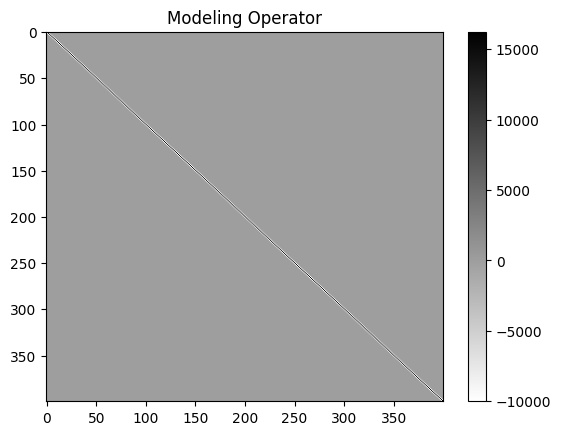

In [5]:
# S matrix
plt.title("Modeling Operator")
plt.imshow(np.real(mat), cmap='binary', aspect='auto')
plt.colorbar()  
plt.show()


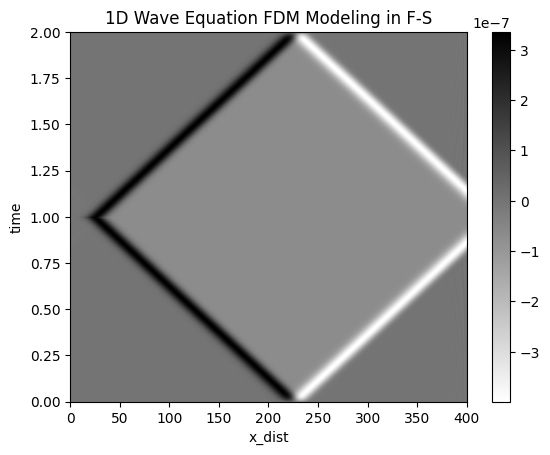

In [2]:

#fdgaus 파형*green 배열로 fdgaus source를 설정해줌
for ix in range(nx):
    #파형적용
    for ifreq in range(nf):
        u[ix, ifreq] = green[ix, ifreq] * csource[ifreq]
    #conjugate로 음의 영역 생성
    for ifreq in range(1,nf):
        u[ix, (nnt-1)-ifreq+1] = np.conj(u[ix, ifreq])

# 역푸리에 후에 nt로 나눠주어야 진폭이 원래와 동일해짐
u = np.fft.ifft(u) / nnt
# attenuation으로 WRAPPING AROUND를 방지하고자 시간영역진폭 복원을 추가로 수행
for it in range (0, nnt):
    u[:,it]=u[:,it]*np.exp(alpha*it*ndt)

# seismogram 출력
plt.xlabel('x_dist')
plt.ylabel('time')
plt.title("1D Wave Equation FDM Modeling in F-S")
plt.imshow(np.real(u), cmap='binary', aspect='auto', extent=[0, nx, 0, tmax])
plt.colorbar()  # Optionally, add a color bar for reference 
plt.show()
